<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Time Series Observation

## Spec2: Assign_wcs()
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* logging
* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot a shape
* pysiaf for SIAF access
* miricoord for coordinate conversion tools
* gwcs for wcs tools
* ci_watson for data retrieval from artifactory

[Top of Page](#title_ID)

In [2]:
import inspect
import numpy as np
from numpy.testing import assert_allclose
import glob
import os
import logging
from IPython.display import Markdown
import jwst.datamodels as datamodels
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy.table import Table, Column
from astropy.utils.data import download_file
from gwcs.wcstools import grid_from_bounding_box

from pysiaf import Siaf
import miricoord.imager.mirim_tools as mt
import miricoord.lrs.toolversions.lrs_pipetools_cdp7 as tv
from miricoord.lrs.lrs_pipetools import xytov2v3lam


from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline

2021-04-22 15:17:18,719 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



<a id="intro_ID"></a>
# Introduction


In this notebook we will test the assign_wcs step of Spec2Pipeline() for **LRS Time Series Observations (TSOs)**, i.e. LRS in slitless mode.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

Pipeline code:  https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated TSO observation, generated with MIRISim v.2.3. It is a single exposure of a star with 100 groups per integration and 10 integrations. LRS TSOs uses the SLITLESSPRISM subarray, so the data do not cover the full array. 

The data are stored on artifactory and we will retrieve from there.

[Top of Page](#title_ID)

In [3]:
exp_file = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_tso3',
                                    'tso3_miri_test',
                                    'pipetest_miri_lrs_tso_100G10I.fits')

configfile = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_tso3',
                                    'tso3_miri_test',
                                    'calwebb_tso1.cfg')

sci_mod = datamodels.open(exp_file)
print(sci_mod)

<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>


<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_tso1.cfg file. The output of this stage will then be run through the assign_wcs step, which is part of the Spec2Pipeline. 

[Top of Page](#title_ID)

### CalDetector1

We first run the data through the Detector1 pipeline, ensuring to pass the calwebb_tso1.cfg configuration file. 

In [4]:
det1_step = Detector1Pipeline()
det1 = det1_step.call(sci_mod, config_file='calwebb_tso1.cfg', save_results=True)

2021-04-22 15:17:21,085 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-04-22 15:17:21,086 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-04-22 15:17:21,088 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-04-22 15:17:21,089 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-04-22 15:17:21,090 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-04-22 15:17:21,091 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-04-22 15:17:21,092 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-04-22 15:17:21,093 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-04-22 15:17:21,094 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-04-22 15:17:21,095 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-04-22 15:17:21,096 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-04-22 15:17:21,097 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-04-22 15:17:21,099 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-04-22 15:17:21,100 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-04-22 15:17:21,101 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-04-22 15:17:21,102 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-04-22 15:17:21,103 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-04-22 15:17:21,608 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0002.asdf


2021-04-22 15:17:21,616 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/io/fits/hdu/hdulist.py:1187: VerifyWarning: Error validating header for HDU #0 (note: Astropy uses zero-based indexing).
    Header size is not multiple of 2880: 478
There may be extra bytes after the last HDU or the file is corrupted.
  warnings.warn(



2021-04-22 15:17:21,624 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-04-22 15:17:21,625 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-04-22 15:17:21,626 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-04-22 15:17:21,627 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-04-22 15:17:21,628 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-04-22 15:17:21,629 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-04-22 15:17:21,630 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-04-22 15:17:21,631 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-04-22 15:17:21,632 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-04-22 15:17:21,633 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-04-22 15:17:21,634 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-04-22 15:17:21,635 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-04-22 15:17:21,635 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-04-22 15:17:21,636 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-04-22 15:17:21,637 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-04-22 15:17:21,639 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-04-22 15:17:21,640 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-04-22 15:17:21,762 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:21,771 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': True, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2021-04-22 15:17:21,779 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'pipetest_miri_lrs_tso_100G10I.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'superbias']


2021-04-22 15:17:21,783 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits'.


2021-04-22 15:17:21,784 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-04-22 15:17:21,785 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-04-22 15:17:21,786 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-04-22 15:17:21,787 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits'.


2021-04-22 15:17:21,788 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-04-22 15:17:21,789 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits'.


2021-04-22 15:17:21,790 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-04-22 15:17:21,791 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-04-22 15:17:21,791 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-04-22 15:17:21,901 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:21,903 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:22,136 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-04-22 15:17:22,136 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-04-22 15:17:22,137 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-04-22 15:17:22,251 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:22,252 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:22,268 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-04-22 15:17:22,543 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2021-04-22 15:17:22,549 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-04-22 15:17:22,691 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:22,693 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:22,709 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-04-22 15:17:22,944 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2021-04-22 15:17:23,174 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-04-22 15:17:23,187 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-04-22 15:17:23,189 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-04-22 15:17:23,340 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:23,341 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:23,342 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-04-22 15:17:23,343 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-04-22 15:17:23,433 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:23,434 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:23,434 - stpipe.Detector1Pipeline.firstframe - INFO - Step skipped.


2021-04-22 15:17:23,435 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-04-22 15:17:23,515 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:23,516 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:23,517 - stpipe.Detector1Pipeline.lastframe - INFO - Step skipped.


2021-04-22 15:17:23,518 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-04-22 15:17:23,593 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:23,594 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:23,611 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits


2021-04-22 15:17:23,635 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-04-22 15:17:23,868 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-04-22 15:17:23,987 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:23,989 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:17:24,004 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-04-22 15:17:24,256 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data


2021-04-22 15:17:24,488 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-04-22 15:17:24,609 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:24,610 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-04-22 15:17:24,610 - stpipe.Detector1Pipeline.rscd - INFO - Step skipped.


2021-04-22 15:17:24,611 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-04-22 15:17:24,698 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:24,699 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-04-22 15:17:24,715 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits


2021-04-22 15:17:24,975 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0


2021-04-22 15:17:24,975 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0


2021-04-22 15:17:25,229 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-04-22 15:17:25,380 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:25,381 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-04-22 15:17:25,389 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-04-22 15:17:25,389 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-04-22 15:17:25,389 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-04-22 15:17:25,390 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-04-22 15:17:25,390 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-04-22 15:17:25,576 - stpipe.Detector1Pipeline.refpix - WARNING - Refpix correction skipped for MIRI subarrays


2021-04-22 15:17:25,577 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-04-22 15:17:25,687 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).


2021-04-22 15:17:25,688 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-04-22 15:17:25,695 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-04-22 15:17:25,704 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 15:17:25,724 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-04-22 15:17:25,743 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-04-22 15:17:25,894 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2021-04-22 15:17:25,982 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-04-22 15:17:26,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-04-22 15:17:26,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3290 pixels with at least one CR


2021-04-22 15:17:26,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-04-22 15:17:26,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3335 pixels with at least one CR


2021-04-22 15:17:26,886 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-04-22 15:17:26,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3362 pixels with at least one CR


2021-04-22 15:17:27,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-04-22 15:17:27,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3353 pixels with at least one CR


2021-04-22 15:17:27,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2021-04-22 15:17:27,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3296 pixels with at least one CR


2021-04-22 15:17:27,765 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2021-04-22 15:17:27,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3315 pixels with at least one CR


2021-04-22 15:17:28,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2021-04-22 15:17:28,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3295 pixels with at least one CR


2021-04-22 15:17:28,344 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2021-04-22 15:17:28,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3284 pixels with at least one CR


2021-04-22 15:17:28,633 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2021-04-22 15:17:28,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3285 pixels with at least one CR


2021-04-22 15:17:28,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2021-04-22 15:17:29,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3317 pixels with at least one CR


2021-04-22 15:17:29,219 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.23631 sec


2021-04-22 15:17:29,221 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.525857


2021-04-22 15:17:29,223 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-04-22 15:17:29,448 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_ramp.fits


2021-04-22 15:17:29,578 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-04-22 15:17:29,579 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-04-22 15:17:29,604 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-04-22 15:17:29,613 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 15:17:29,623 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-04-22 15:17:29,623 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-04-22 15:17:29,624 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2021-04-22 15:17:29,701 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2021-04-22 15:18:36,823 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 100


2021-04-22 15:18:36,824 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 10


2021-04-22 15:18:36,842 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-04-22 15:18:36,989 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-04-22 15:18:36,990 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:18:37,019 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 15:18:37,020 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 15:18:37,021 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 15:18:37,113 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).


2021-04-22 15:18:37,114 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-04-22 15:18:37,137 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 15:18:37,138 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 15:18:37,139 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 15:18:37,180 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_rateints.fits


2021-04-22 15:18:37,180 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-04-22 15:18:37,212 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_rate.fits


2021-04-22 15:18:37,212 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


### AssignWcs

The AssignWcs step should not change anything in the science data or error extension. It attaches the WCS information to the data, so that a location in detector pixels can be reconstructed to an RA, dec, wavelength in spatial and spectral space. 

In [5]:
rfile = glob.glob('pipetest*_rate.fits')
rifile = glob.glob('pipetest*_rateints.fits')
print(rfile)
print(rifile)

rmod = ImageModel(rfile[0])
rimod = CubeModel(rifile[0])

wcs_step = AssignWcsStep()
wcsmod = wcs_step.call(rifile[0], save_results=True)

2021-04-22 15:18:37,217 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-04-22 15:18:37,268 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-04-22 15:18:37,303 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-04-22 15:18:37,400 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stpipe/step.py:359: ResourceWarning: unclosed file <_io.FileIO name='pipetest_miri_lrs_tso_100G10I_rateints.fits' mode='rb' closefd=True>
  gc.collect()



2021-04-22 15:18:37,402 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('pipetest_miri_lrs_tso_100G10I_rateints.fits',).


2021-04-22 15:18:37,403 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


['pipetest_miri_lrs_tso_100G10I_rate.fits']
['pipetest_miri_lrs_tso_100G10I_rateints.fits']


2021-04-22 15:18:37,695 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-slitless pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-04-22 15:18:37,742 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-04-22 15:18:37,746 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000981120 -0.000094311 0.000981120 0.000098852 359.998963682 0.000098852 359.998963682 -0.000094311


2021-04-22 15:18:37,747 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000981120 -0.000094311 0.000981120 0.000098852 359.998963682 0.000098852 359.998963682 -0.000094311


2021-04-22 15:18:37,747 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-04-22 15:18:37,851 - stpipe.AssignWcsStep - INFO - Saved model in pipetest_miri_lrs_tso_100G10I_assignwcsstep.fits


2021-04-22 15:18:37,851 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


<a id="residual_ID"></a>
## Output checks and tests

We can use the output model to run teh following checks:

* the SCI extension is unchanged from the step input (check with 1 integration)
* we visualize the location of the bounding box.
* we use the wcs information assigned in the step to check the RA, dec, wavelength assignment at some reference locations. 

[Top of Page](#title_ID)

2021-04-22 15:18:37,855 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



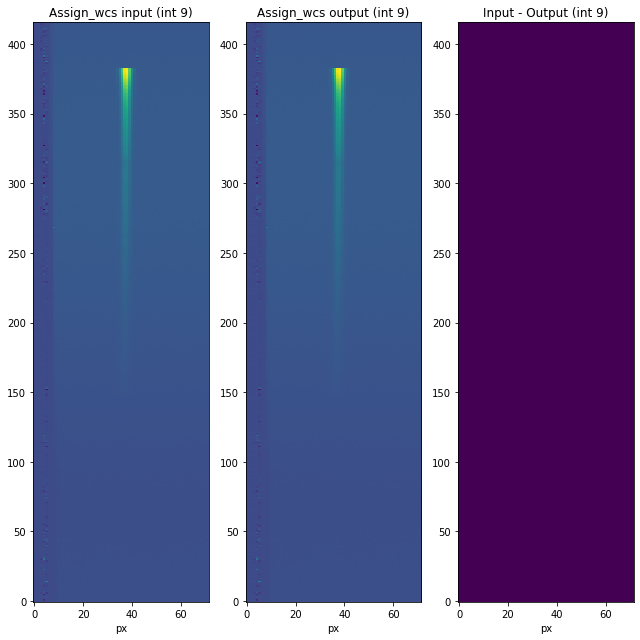

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[9,9])
ax[0].imshow(rimod.data[9,:,:], origin='lower', interpolation='None', aspect='auto')
ax[0].set_title('Assign_wcs input (int 9)')
ax[0].set_xlabel('px')
ax[0].set_xlabel('px')

ax[1].imshow(wcsmod.data[9,:,:], origin='lower', interpolation='None', aspect='auto')
ax[1].set_title('Assign_wcs output (int 9)')
ax[1].set_xlabel('px')
ax[1].set_xlabel('px')

diff = rimod.data[9,:,:] - wcsmod.data[9,:,:]
ax[2].imshow(diff, origin='lower', interpolation='None', aspect='auto')
ax[2].set_title('Input - Output (int 9)')
ax[2].set_xlabel('px')
ax[2].set_xlabel('px')

fig.tight_layout()

# Do a numeric check between input and output
assert np.mean(diff) <= 1e-6, "Check differences between step input and output"

In [7]:
bbox_w = wcsmod.meta.wcs.bounding_box[0][1] - wcsmod.meta.wcs.bounding_box[0][0]
bbox_ht = wcsmod.meta.wcs.bounding_box[1][1] - wcsmod.meta.wcs.bounding_box[1][0]
print('Model bbox = {0} '.format(wcsmod.meta.wcs.bounding_box))
print('Model: Height x width of bounding box = {0} x {1} pixels'.format(bbox_ht, bbox_w))

# make sure that the size of the bounding box is smaller than the subarray
assert bbox_ht <= np.shape(wcsmod.data)[1], "Bounding box size incompatible with subarray"
assert bbox_w <= np.shape(wcsmod.data)[2], "Bounding box size incompatible with subarray"

Model bbox = ((3.5, 71.5), (6.5, 397.5)) 
Model: Height x width of bounding box = 391.0 x 68.0 pixels


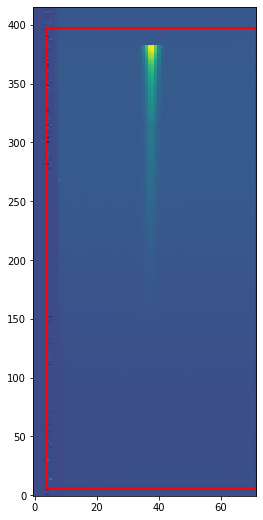

In [8]:
fig, ax = plt.subplots(figsize=[4,9])
bbox = Rectangle((wcsmod.meta.wcs.bounding_box[0][0],wcsmod.meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

ax.imshow(wcsmod.data[9,:,:], origin='lower', interpolation='None', aspect='auto')
ax.add_patch(bbox)

2021-04-22 15:18:38,333 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/pysiaf/aperture.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  degree = np.int(getattr(self, 'Sci2IdlDeg'))



2021-04-22 15:18:38,334 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/pysiaf/utils/polynomial.py:378: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_coefficients = np.int((poly_degree + 1) * (poly_degree + 2) / 2)



(38.5, 829.0)
(array([ 0.5, 72.5, 72.5,  0.5]), array([528.5, 528.5, 944.5, 944.5]))
(37.0, 299.5)


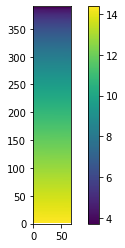

In [9]:
# Plot the wavelength solution based on the wcs information in the model
siaf = Siaf('MIRI')
ap = siaf['MIRIM_SLITLESSPRISM']
refpx = ap.reference_point(to_frame='det')
apcorners = ap.corners(to_frame='det')
print(refpx)
print(apcorners)

refpx_sub = (refpx[0] - apcorners[0][0] - 1, refpx[1] - apcorners[1][0] - 1)
print(refpx_sub)

x,y = grid_from_bounding_box(wcsmod.meta.wcs.bounding_box)
ra, dec, lam = wcsmod.meta.wcs(x, y)

fig = plt.figure()
plt.imshow(lam, origin='lower', interpolation='None')
plt.colorbar()

In [10]:
xt,yt,v2t,v3t,lamt,stype=tv.testdata()
print(xt[1], yt[1], lamt[1], v2t[1], v3t[1])

lamtest1 = np.zeros(3)
v2test1 = np.zeros(3)
v3test1 = np.zeros(3)
lt1 = np.zeros(3)

print('**** TEST SET ****')
print(' x       y     lam_truth  lamtest1  v2truth   v3truth  v2test   v3test')
for i in range (3):
    v2test1[i], v3test1[i], lt1[i] = xytov2v3lam(xt[1][i], yt[1][i], 'slitless') 
    ra, dec, lamtest1[i] = wcsmod.meta.wcs(xt[1][i], yt[1][i])
    print('{0}  {1}   {2}    {3:.5f}   {4:.5f}   {5:.5f}   {6:.5f}   {7:.5f}'.format(xt[1][i], yt[1][i], lamt[1][i], lamtest1[i], v2t[1][i], v3t[1][i], v2test1[i], v3test1[i]))
    
    
    assert_allclose(lamt[1][i], lamtest1[i], atol=0.05)
    assert_allclose(v2t[1][i], v2test1[i], atol=0.05)
    assert_allclose(v3t[1][i], v3test1[i], atol=0.05)

[37.5 37.5 17.5] [300.  29. 370.] [ 8.41039 14.0694   5.7303 ] [-378.832  -378.9571 -376.6104] [-344.9445 -344.9331 -345.1475]
**** TEST SET ****
 x       y     lam_truth  lamtest1  v2truth   v3truth  v2test   v3test


37.5  300.0   8.41039    8.41039   -378.83200   -344.94450   -378.83207   -344.94454


37.5  29.0   14.0694    14.06942   -378.95710   -344.93310   -378.95713   -344.93313


17.5  370.0   5.7303    5.73033   -376.61040   -345.14750   -376.61044   -345.14752


**If the above ``assert_allclose`` tests PASS, the test is successful and complete.**

<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA MIRI Instrument & Calibration Scientist, MIRI branch
<br>**Updated On:** 12/14/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 